In [1]:
import time
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import murmurhash3_32
from sklearn.cluster import KMeans
import scipy.spatial.distance as distance

from cluster import spectrum
import nb_utils

In [2]:
charge = 2
mz_split = 602
path = '/media/maesk/WD/falcon/PXD000561_all/spectra'
limit = 1001

min_mz, max_mz = 101., 1500.
fragment_mz_tolerance = 0.05
n_components = 800
vec_len, min_bound, max_bound = spectrum.get_dim(min_mz, max_mz, fragment_mz_tolerance)
hash_lookup = np.asarray([murmurhash3_32(i, 0, True) % n_components
                              for i in range(vec_len)], np.uint32)

sps = []

cnt = 0
for sp in nb_utils.read_spectra_from_bucket(charge, path, mz_split):
    if limit is not None and cnt >= limit:
        break
    sp = nb_utils.process_spectrum(sp)
    if sp is not None:
        sps.append(sp)
        cnt = cnt + 1

vec_falcon = spectrum.to_vector_parallel(sps, n_components, min_mz, max_mz,
                                         fragment_mz_tolerance, hash_lookup, True)

print(np.shape(vec_falcon))

(1001, 800)


In [3]:
def analyze_kmeans_clusters(kmeans, vec_falcon):
    n_clusters, _ = np.shape(kmeans.cluster_centers_)

    n_noise = 0
    min_dists = []
    max_dists = []
    av_dists = []

    for i in range(n_clusters):
        centroid = kmeans.cluster_centers_[i,:]
        mask = np.where(kmeans.labels_ == i)[0]
        assigned_sp = vec_falcon[mask,:]
        n_sp, _ = np.shape(assigned_sp)

        if n_sp > 1:
            curr_dists = []
            for i in range(n_sp-1):
                for j in range(i+1, n_sp):
                    curr_dists.append(distance.cosine(assigned_sp[i,:],
                                                      assigned_sp[j,:]))
            min_dists.append(min(curr_dists))
            max_dists.append(max(curr_dists))
            av_dists.append(np.mean(curr_dists))
        else:
            n_noise = n_noise + 1

    return np.mean(min_dists), np.mean(max_dists), np.mean(av_dists), n_noise

In [5]:
init = 'random'
all_n_clusters = range(1, 32, 1)
# all_n_clusters = [50, 100, 200]
data = {'n_clusters': all_n_clusters,
        'inertias': [],
        'av_min': [],
        'av_max': [],
        'av_mean': [],
        'prop_noise': []}

for n_clusters in all_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vec_falcon)
    print('%d : %.2f' % (n_clusters, kmeans.inertia_) )
    data['inertias'].append(kmeans.inertia_)
    av_min, av_max, av_mean, n_noise = analyze_kmeans_clusters(kmeans, vec_falcon)
    data['av_min'].append(av_min)
    data['av_max'].append(av_max)
    data['av_mean'].append(av_mean)
    data['prop_noise'].append(n_noise/n_clusters)
    print(av_min, av_max, av_mean)

1 : 839.48
0.001761794090270996 1.0 0.8394827393631807
2 : 771.87
0.0018256902694702148 0.8228439539670944 0.5105108522156081
3 : 718.41
0.002524137496948242 0.7771350940068563 0.40642313346919323
4 : 680.62
0.002935737371444702 0.7647862285375595 0.3678993726385534
5 : 657.00
0.0032166600227355956 0.801680964231491 0.43769385028827024
6 : 633.96
0.005647708972295125 0.8075055330991745 0.4616005161975765
7 : 602.04
0.005739373820168632 0.7991506638936698 0.4138265956661012
8 : 580.43
0.007280826568603516 0.8044036570936441 0.42976183978197113
9 : 563.67
0.010013202826182047 0.821745503693819 0.44152888296601406
10 : 558.16
0.008638370037078857 0.8158243489451706 0.438952356427498
11 : 543.04
0.010309782895174894 0.8359142050824382 0.44237643203312726
12 : 532.09
0.011080846190452576 0.8300320660928264 0.43554802240283363
13 : 527.10
0.01197346357198862 0.8104610884418855 0.4025031890609125
14 : 511.09
0.012875092881066459 0.80162316424373 0.41166181212446007
15 : 503.55
0.0129161516825

In [7]:
for k, v in data.items():
    data[k] = np.asarray(v)

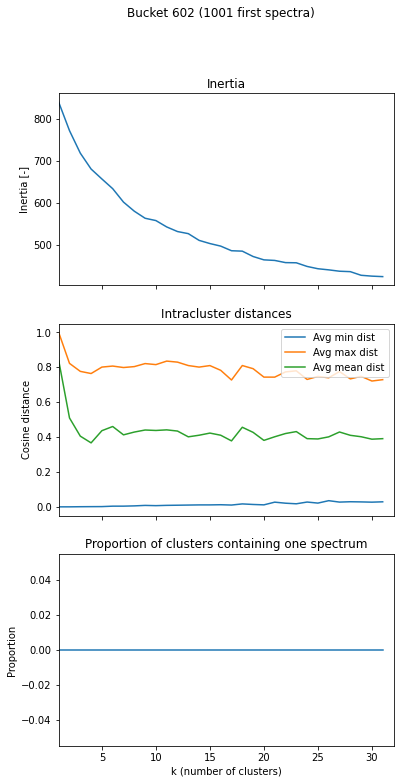

In [9]:
interval_plt = (1, 32)
data_plt = {}
mask = np.where( (data['n_clusters'] >= interval_plt[0]) & (data['n_clusters'] <= interval_plt[1]))[0]
for k, v in data.items():
    data_plt[k] = data[k][mask]

fig, axs = plt.subplots(3, 1, figsize=(6,12), sharex=True)
fig.suptitle(f'Bucket {mz_split} ({limit} first spectra)')

axs[0].plot(data_plt['n_clusters'], data_plt['inertias'])
axs[0].set(title='Inertia', ylabel='Inertia [-]')

axs[1].plot(data_plt['n_clusters'], data_plt['av_min'], label='Avg min dist')
axs[1].plot(data_plt['n_clusters'], data_plt['av_max'], label='Avg max dist')
axs[1].plot(data_plt['n_clusters'], data_plt['av_mean'], label='Avg mean dist')
axs[1].set(title='Intracluster distances',
           ylabel='Cosine distance')
axs[1].legend()

axs[2].plot(data_plt['n_clusters'], data_plt['prop_noise'])
axs[2].set(title='Proportion of clusters containing one spectrum',
           xlabel='k (number of clusters)', ylabel='Proportion')

for ax in axs:
    ax.set(xlim=interval_plt)

plt.savefig(f'kmeans/{time.time()}.png', dpi=300)
plt.show()